In [ ]:
!pip install keras.preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.corpus.reader.conll import ConllCorpusReader
import numpy as np
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input
from tensorflow.keras import Model
#from keras_contrib.layers import CRF
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, Flatten, SpatialDropout1D, GlobalMaxPooling1D

reader = ConllCorpusReader('/content/drive/MyDrive/data/', 'eng.train', ('words', 'pos', 'chunk', 'ne'))
grid = reader._grids()

sentences = list(grid) 

#Removing the first empty entry
sentences = sentences[1:]

all_words = (reader.words())

words = list(set(all_words))
words.append("ENDPAD")

n_words = len(words)

all_tags_in_sentence = [[c[3] for c in sentence] for sentence in sentences]
all_tags = []

for sentence in all_tags_in_sentence:
    for c in sentence:
        all_tags.append(c)

tags = set(all_tags)
n_tags = len(tags)

all_pos_in_sentence = [[c[1] for c in sentence] for sentence in sentences]
all_pos = []

for sentence in all_pos_in_sentence:
    for c in sentence:
        all_pos.append(c)

pos = set(all_pos)
n_pos = len(pos)

all_chunk_in_sentence = [[c[2] for c in sentence] for sentence in sentences]
all_chunk = []

for sentence in all_chunk_in_sentence:
    for c in sentence:
        all_chunk.append(c)

chunks = set(all_chunk)
n_chunks = len(chunks)

#prep

max_len = 65
print(max_len)

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {t: i + 1 for i, t in enumerate(pos)}
pos2idx["PAD"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

chunks2idx = {t: i + 1 for i, t in enumerate(chunks)}
chunks2idx["PAD"] = 0
idx2chunks = {i: w for w, i in chunks2idx.items()}

#padding

X_word = [[word2idx[w[0]] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

X_pos = [[pos2idx[w[1]] for w in s] for s in sentences]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')

X_chunk = [[chunks2idx[w[2]] for w in s] for s in sentences]
X_chunk = pad_sequences(maxlen=max_len, sequences=X_chunk, value=chunks2idx["PAD"], padding='post', truncating='post')

y = [[tag2idx[w[3]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.1, random_state=2018)
X_chunk_tr, X_chunk_te, _, _ = train_test_split(X_chunk, y, test_size=0.1, random_state=2018)



# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words+2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)
                     
# main LSTM
x = concatenate([emb_word])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6, activation="relu"))(x)
out = TimeDistributed(Dense(n_tags+1, activation="relu"))(main_lstm)
model = Model(word_in, out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(X_word_tr, 
                    np.array(y_tr).reshape(len(y_tr), max_len, 1), 
                    batch_size=512, epochs=30, validation_split=0.15, verbose=1)


65
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65)]              0         
                                                                 
 embedding (Embedding)       (None, 65, 20)            472520    
                                                                 
 concatenate (Concatenate)   (None, 65, 20)            0         
                                                                 
 spatial_dropout1d (SpatialD  (None, 65, 20)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 65, 100)          28400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 65, 9)            909

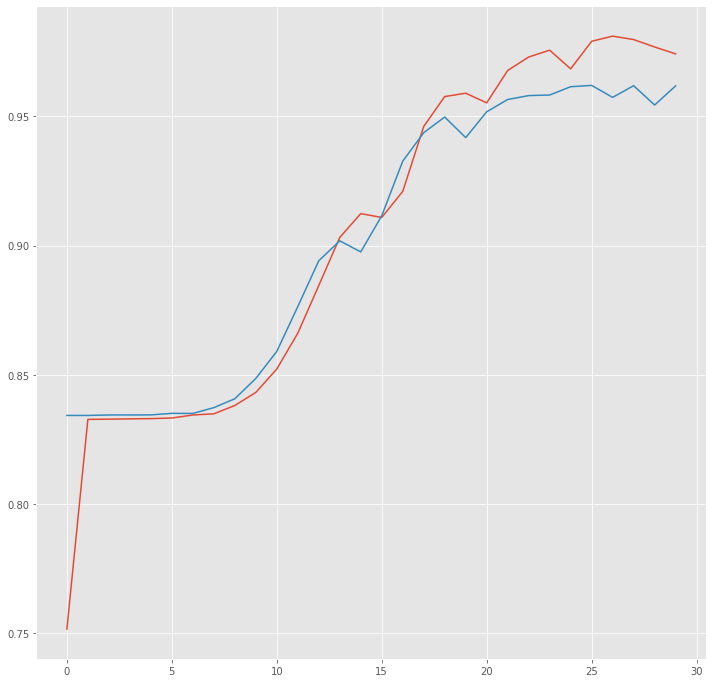

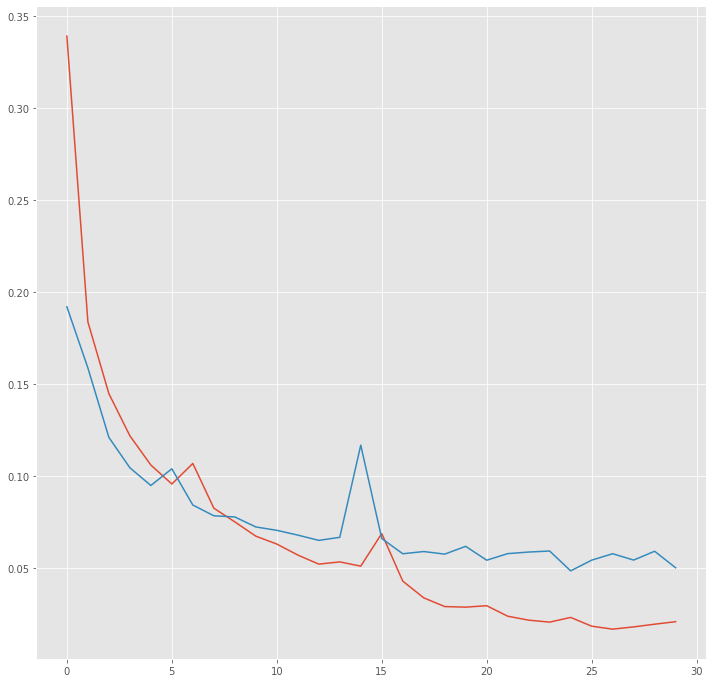

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()



In [ ]:
y_pred = model.predict(X_word_te)

for i in range(10):
  p = np.argmax(y_pred[i], axis=-1)
  print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
  print(30 * "=")
  for w, t, pred in zip(X_word_te[i], y_te[i], p):
      if w != 0:
          print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

47/47 [==============================] - 2s 26ms/step
Word           ||True ||Pred
Men            : O     O
's             : O     O
singles        : O     O
Word           ||True ||Pred
5.             : O     O
Peter          : I-PER I-PER
Dirkx          : I-PER I-PER
(              : O     O
Belgium        : I-LOC I-LOC
)              : O     O
KTM            : I-ORG I-ORG
Word           ||True ||Pred
For            : O     O
the            : O     O
first          : O     O
time           : O     O
,              : O     O
the            : O     O
Democratic     : I-ORG I-ORG
Party          : I-ORG I-ORG
has            : O     O
included       : O     O
in             : O     O
our            : O     O
platform       : O     O
a              : O     O
conscience     : O     O
clause         : O     O
,              : O     O
"              : O     O
he             : O     O
said           : O     O
.              : O     O
Word           ||True ||Pred
Argentine      : I-MISC I-MISC


In [ ]:
fp, fn, tp= 0,0,0

for i in range(y_te.shape[0]):
  p = np.argmax(y_pred[i], axis=-1)
  for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
      if(t == pred):
        tp=tp+1
      elif(t == 6):
        fp=fp+1
      else:
        fn=fn+1

accuracy = tp/(tp+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1=2*precision*recall/(precision+recall)

print("accuracy\n", accuracy, "\nprecision:\n", precision, "\nrecall:\n", recall, "\nf1:\n", f1)


accuracy
 0.9569949434143993 
precision:
 0.9869871858547731 
recall:
 0.9692240159976588 
f1:
 0.9780249526293772
